In [55]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [58]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [59]:
love_snippets.loc[[132, 2382]]

,transcript,url,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,12.0,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,15.0,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [60]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [61]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=True)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.02128322 0.01730651]
3 topics variance ratios: [0.02128322 0.0173051  0.01293146]
4 topics variance ratios: [0.02128323 0.0173057  0.01291997 0.01072132]
5 topics variance ratios: [0.02128323 0.01730594 0.01293525 0.01073982 0.00946571]


# The 2-Topic Result

In [62]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, think, feel, people, say, want, got, like, don, time, life, years


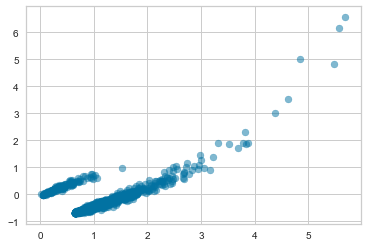

In [64]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

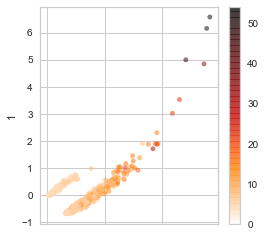

In [8]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

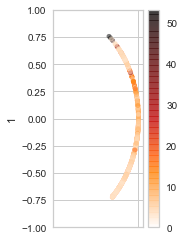

In [9]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

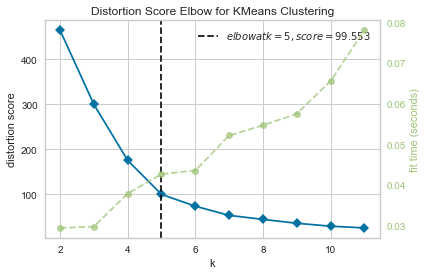

In [10]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [11]:
visualizer.elbow_value_

5

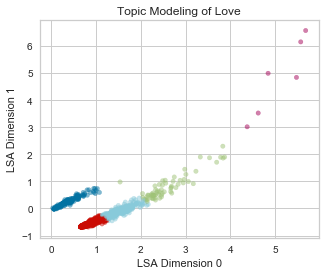

In [12]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [13]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 0.87313434 -0.54577895]
g [2.58769929 0.80692428]
b [0.38457907 0.25747981]
c [ 1.4814366  -0.13262996]
m [5.09312782 4.85135835]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [14]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.563353,1.622633,1.072664,0.171993,6.317472
1,0.294896,1.889213,0.960028,0.440812,6.567503
2,0.116859,2.300786,0.960973,0.851966,6.964584
3,0.634994,1.557280,1.142548,0.109870,6.264814
4,2.792112,0.614072,2.804412,2.062337,4.156369


Show the snippets from the 4 (euclidean distance) closest documents:

In [15]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87313434 -0.54577895] color= r
815 : [ 0.87827247 -0.54874425] His story is the following: He was recruited when he was 17, and sometime later, in his squadron, if you will, this beautiful girl was recruited, and they fell in love. But it turns out that love is very strictly forbidden in the lower ranks of the guerrilla, so their romance was discovered and they were separated. We'd love to help.
990 : [ 0.86766791 -0.53794048] (Laughter)Now, I love this species despite the fact that it tried to kill us, and that's because this species in Madagascar, its closest relatives are 6,000 kilometers away, cavefishes in Australia.
573 : [ 0.86793694 -0.53734854] Because probably some of the things that we love most are going to be also the things that can hurt us most.
626 : [ 0.88276757 -0.54136666] Mike deGruy was also invited, and he spoke with great passion about his love of the ocean, and he also talked to me about applying my approach to something he's been involv

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

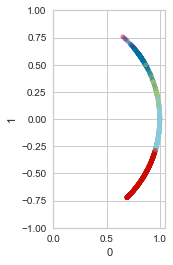

In [16]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [17]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87313434 -0.54577895] color= r
815 : [ 0.87827247 -0.54874425] His story is the following: He was recruited when he was 17, and sometime later, in his squadron, if you will, this beautiful girl was recruited, and they fell in love. But it turns out that love is very strictly forbidden in the lower ranks of the guerrilla, so their romance was discovered and they were separated. We'd love to help.
641 : [ 0.94666749 -0.59263898] It's made into a grade where it's not usable for a nuclear weapon, but they love this stuff. Well, we're securing them, and it would be great if we could burn them, eat them up, and this reactor loves this stuff. So you have what's called the xenon pit, and so some of these fission products love neutrons. They love the neutrons that are going on and helping this reaction take place.
734 : [ 0.90814325 -0.5689986 ] Another example, one of my favorite insects, I love to hate this one, is a mosquito, and you're seeing the antenna of a culex 

Now clustering on the 

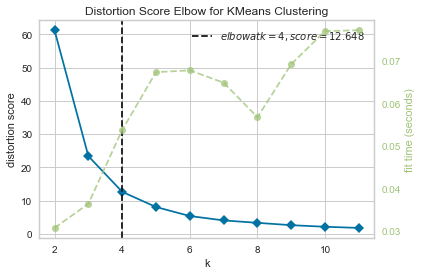

In [18]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

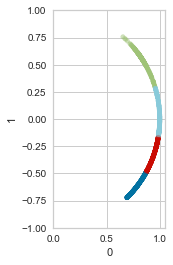

In [19]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [20]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.93541328 -0.33921327] color= r
326 : [ 0.94009047 -0.34092508] Actually, I fell in love with the ocean when I was a little boy, when I was about eight or nine. I saw grottoes and secret gardens and places I'd love to hide as a kid, if I could only breathe underwater. I love to draw the deep sea fish, because they are so ugly, but beautiful in their own way. This is what I love about comic strips, you know.
7 : [ 0.94024185 -0.34050736] I just, this is why I love what Michael does, because it's like, if he's debunking it, then I don't have to.
1041 : [ 0.94032154 -0.34028722] The news loved it. Better than that, my theorist colleagues — I love my theorist colleagues — my theorist colleagues wrote 500 papers about this little bump.
860 : [ 0.94070555 -0.33922422] I would love to give you a little perspective on what a day in my life can look like.


Cluster centered at: [0.83545356 0.53822698] color= g
661 : [0.84062159 0.54162287] Now, he really loved to issue p

# The 3-Topic Result

In [21]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, person, just, think, feel, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, thinking, know, lot, brain, romantic, ve, little, work, single, start


In [22]:
cv_doc_topic[1]

array([[ 1.33989852, -0.22835622, -0.63959146],
       [ 1.11049001, -0.3716323 ,  0.1086266 ],
       [ 0.78114609, -0.61835309,  0.18682394],
       ...,
       [ 0.74191763, -0.62444019,  0.16197058],
       [ 1.1303786 , -0.56986192,  0.17756212],
       [ 0.87370695, -0.57870372,  0.03215449]])

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

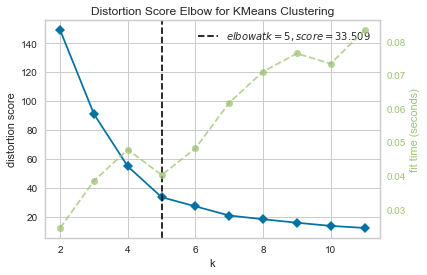

In [25]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [50]:
num_clusters = 4 #visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


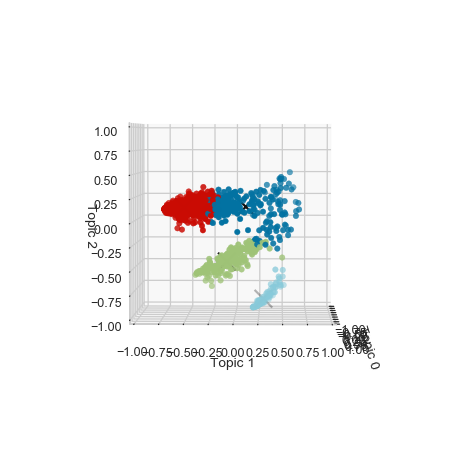

In [53]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=200,c='k')
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [31]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.78421558 -0.58923632  0.15182291] color= r
665 : [ 0.78836576 -0.59592993  0.15279707] Let's say you're in love.
196 : [ 0.79230669 -0.59104127  0.15139462] (Laughter)I love my job. This is the — I love this — the boss call. I love the Wired headline: Pigs Fly, Hell Freezes Over and Verizon Opens Up Its Network — No.
601 : [ 0.79238974 -0.5905387   0.15291352] And it's a very effective way of ending your hate mail: "Love Markham, Aged 4. " (Rain and wind sounds)(Explosion) Oh, shit!Markham Nolan: Okay, so now if you're a news producer, this is something you'd love to run with, because obviously, this is gold.
961 : [ 0.78986074 -0.59228088  0.15913319] I'd love to sit down with him, wherever he is, and share with him how much the time I spent on Smoky Mountain inspired me.


Cluster centered at: [ 0.42588568  0.30324826 -0.83450061] color= g
416 : [ 0.43110858  0.30098662 -0.85061886] He loved intellectual battle. He loved to win, win these little macho games w

# The 4-Topic Result

In [35]:
display_topics(cv_lsa[2], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, think, feel, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, thinking, lot, romantic, brain, ve, little, work, single, start, drive

Topic  3
loved, love, fell, idea, doing, times, instead, great, thought, didn, version, experiences, generous, real


In [65]:
doc_topic = cv_doc_topic[2]
df = pd.DataFrame(normalize(cv_doc_topic[2]))

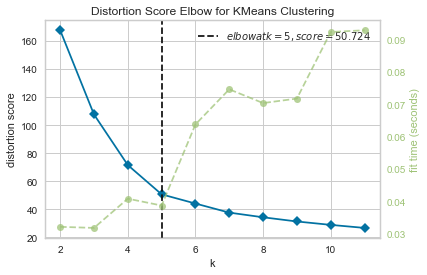

In [66]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [67]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


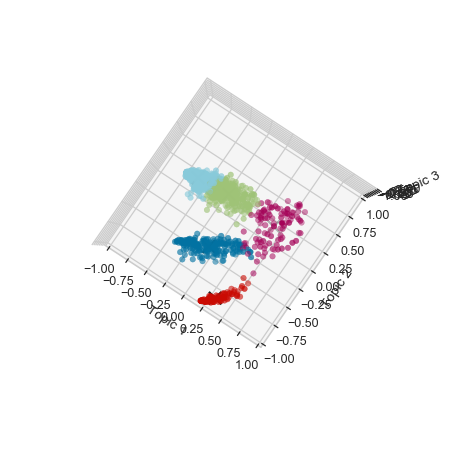

In [79]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.set_xlabel('Topic 1')
ax.set_ylabel('Topic 2')
ax.set_zlabel('Topic 3')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

In [40]:
doc_topic = cv_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.78419464 -0.57680861  0.1542148   0.07609817] color= r
470 : [ 0.80478393 -0.56862372  0.15564385  0.0690281 ] And this is the part — it's the part I just love.
770 : [ 0.78156091 -0.60137565  0.14825988  0.07435643] I'd love to tell you that I didn't flinch, but I was terrified, and when my fear subsided, I became obsessed with finding out how this happened, how animal rights and environmental activists who have never injured anyone could become the FBI's number one domestic terrorism threat.
665 : [ 0.7872585  -0.59448667  0.15380869  0.05614738] Let's say you're in love.
704 : [ 0.78253038 -0.59988836  0.14360908  0.0845966 ] They usually love their grandchildren, and are eager to spend time with them.


Cluster centered at: [ 0.87965045 -0.06772209 -0.40064209  0.05583069] color= g
510 : [ 0.90623228 -0.08088462 -0.41224419  0.0474918 ] And so many of the calls went like this, "Dr. Brown, we loved your TED talk. It wasn't until a man looked at me after a bo